## Maximum Common Substructure Analysis

In [28]:
from welqrate.dataset import WelQrateDataset
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS


In [8]:
AID1798_dataset_2d = WelQrateDataset(dataset_name = 'AID1798', root =f'./welqrate_data', mol_repr ='2dmol')
print(AID1798_dataset_2d[0])

dataset stored in ./welqrate_data/AID1798
Dataset AID1798 loaded.
Number of active molecules: 164
Number of inactive molecules: 60542
Data(x=[21, 28], edge_index=[2, 44], edge_attr=[44, 7], one_hot_atom=[21, 12], atom_num=[21], num_edges=[1], inchi='InChI=1S/C18H29NO2/c1-13-8-9-14(2)18(10-13)21-12-17(20)11-19-15(3)6-5-7-16(19)4/h8-10,15-17,20H,5-7,11-12H2,1-4H3', y=[1], pubchem_cid=[1], mol_id=[1], smiles='Cc1ccc(C)c(OCC(O)CN2C(C)CCCC2C)c1', num_nodes=[1])


In [4]:
split_scheme = 'random_cv1'
split_dict = AID1798_dataset_2d.get_idx_split(split_scheme)

loading random split cv1
train set: 100 actives and 36326 inactives
valid set: 32 actives and 12108 inactives
test set: 32 actives and 12108 inactives


In [9]:
train_idx = split_dict['train']
train_data = AID1798_dataset_2d[train_idx]
train_actives = [data for data in train_data if data.y == 1]

In [42]:
train_actives_smiles = [data.smiles for data in train_actives]

train_dict = {data.smiles: str(data.y.item()) for data in train_data}

In [31]:
from typing import Union
def SmilesMCStoGridImage(smiles: Union[list[str], dict[str, str]], 
                         align_substructure: bool = True, verbose: bool = False, **kwargs):
     """
     Convert a list (or dictionary) of SMILES strings to an RDKit grid image of the maximum common substructure (MCS) match between them

     :returns: RDKit grid image, and (if verbose=True) MCS SMARTS string and molecule, and list of molecules for input SMILES strings
     :rtype: RDKit grid image, and (if verbose=True) string, molecule, and list of molecules
     :param molecules: The SMARTS molecules to be compared and drawn
     :type molecules: List of (SMARTS) strings, or dictionary of (SMARTS) string: (legend) string pairs
     :param align_substructure: Whether to align the MCS substructures when plotting the molecules; default is True
     :type align_substructure: boolean
     :param verbose: Whether to return verbose output (MCS SMARTS string and molecule, and list of molecules for input SMILES strings); default is False so calling this function will present a grid image automatically
     :type verbose: boolean
     """
     mols = [Chem.MolFromSmiles(smile) for smile in smiles]
     res = rdFMCS.FindMCS(mols, **kwargs)
     mcs_smarts = res.smartsString
     mcs_mol = Chem.MolFromSmarts(res.smartsString)
     smarts = res.smartsString
     smart_mol = Chem.MolFromSmarts(smarts)
     smarts_and_mols = [smart_mol] + mols

     smarts_legend = "Max. substructure match"

     # If user supplies a dictionary, use the values as legend entries for molecules
     if isinstance(smiles, dict):
          mol_legends = [smiles[molecule] for molecule in smiles]
     else:
          mol_legends = ["" for mol in mols]

     legends =  [smarts_legend] + mol_legends
    
     matches = [""] + [mol.GetSubstructMatch(mcs_mol) for mol in mols]

     subms = [x for x in smarts_and_mols if x.HasSubstructMatch(mcs_mol)]

     Chem.Compute2DCoords(mcs_mol)

     if align_substructure:
          for m in subms:
               _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

     drawing = Draw.MolsToGridImage(smarts_and_mols, highlightAtomLists=matches, legends=legends)

     if verbose:
          return drawing, mcs_smarts, mcs_mol, mols
     else:
          return drawing


/home/allenwang/miniconda3/envs/digress/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


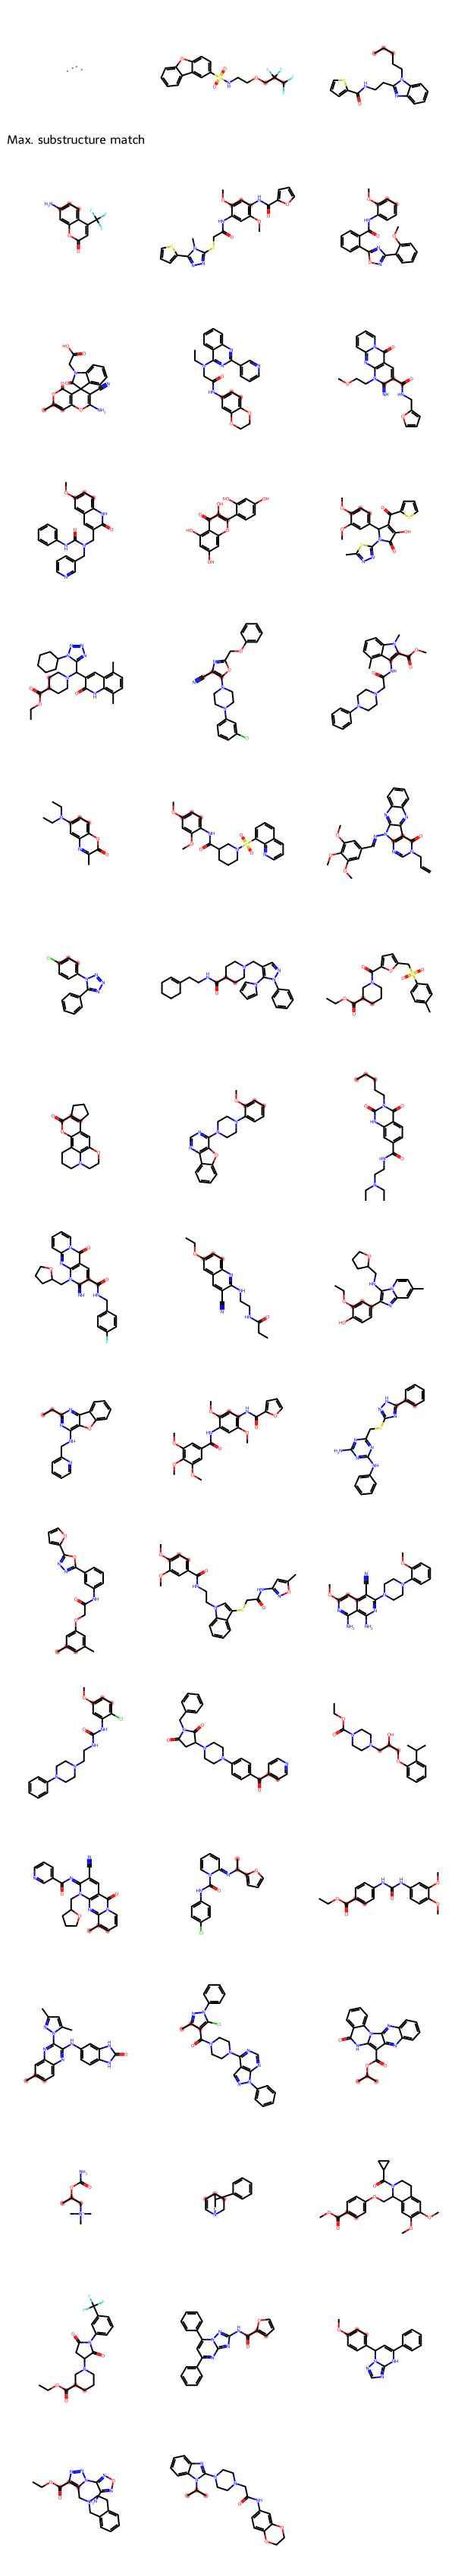

In [32]:
SmilesMCStoGridImage(train_actives_smiles)

## Fragment Vocabulary

In [53]:
from rdkit import Chem
from rdkit.Chem import BRICS

def generate_brics_fragments(smiles_list):
    smiles_to_fragments = {}  # Dictionary to store smiles: [fragments] pairs
    fragments = set()
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        frags = list(BRICS.BRICSDecompose(mol, keepNonLeafNodes=True))
        smiles_to_fragments[smiles] = frags
        fragments.update(frags)
    return smiles_to_fragments, fragments

fragments_dict, fragments = generate_brics_fragments(train_actives_smiles)
print(f"Number of molecules decomposed: {len(fragments_dict)}")
# Print example of first molecule and its fragments
first_smiles = list(fragments_dict.keys())[0]
print(f"\nExample decomposition:")
print(f"Original SMILES: {first_smiles}")
print(f"Fragments: {fragments_dict[first_smiles]}")

# total number of unique fragments
print(f"Total number of unique fragments: {len(fragments)}")


Number of molecules decomposed: 100

Example decomposition:
Original SMILES: O=S(=O)(NCCOCC(F)(F)C(F)F)c1ccc2oc3ccccc3c2c1
Fragments: ['[3*]O[3*]', '[4*]CCNS(=O)(=O)c1ccc2oc3ccccc3c2c1', '[4*]CC(F)(F)C(F)F', '[4*]CCOCC(F)(F)C(F)F', 'O=S(=O)(NCCOCC(F)(F)C(F)F)c1ccc2oc3ccccc3c2c1', '[5*]NS(=O)(=O)c1ccc2oc3ccccc3c2c1', '[3*]OCCN[5*]', '[3*]OCC[4*]', '[5*]NCCOCC(F)(F)C(F)F', '[4*]CC[4*]', '[12*]S(=O)(=O)c1ccc2oc3ccccc3c2c1', '[5*]N[5*]', '[4*]CCN[5*]', '[3*]OCC(F)(F)C(F)F', '[3*]OCCNS(=O)(=O)c1ccc2oc3ccccc3c2c1']
Total number of unique fragments: 1800


In [59]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def categorize_fragments(fragments):
    # Create size categories
    tiny_frags = []      # 1-3 heavy atoms
    small_frags = []     # 4-6 heavy atoms
    medium_frags = []    # 7-12 heavy atoms
    large_frags = []     # 13+ heavy atoms
    
    for frag in fragments:
        frag = Chem.MolFromSmiles(frag)
        n_atoms = frag.GetNumHeavyAtoms()
        if n_atoms <= 3:
            tiny_frags.append(frag)
        elif n_atoms <= 6:
            small_frags.append(frag)
        elif n_atoms <= 12:
            medium_frags.append(frag)
        else:
            large_frags.append(frag)
            
    return {
        'tiny': tiny_frags,
        'small': small_frags,
        'medium': medium_frags,
        'large': large_frags
    }

categorized_fragments = categorize_fragments(fragments)
print('number of fragments in each category:')
print(f'tiny: {len(categorized_fragments["tiny"])}')
print(f'small: {len(categorized_fragments["small"])}')
print(f'medium: {len(categorized_fragments["medium"])}')
print(f'large: {len(categorized_fragments["large"])}')

number of fragments in each category:
tiny: 48
small: 118
medium: 457
large: 1177



Molecule 1
SMILES: O=S(=O)(NCCOCC(F)(F)C(F)F)c1ccc2oc3ccccc3c2c1
Number of fragments: 15


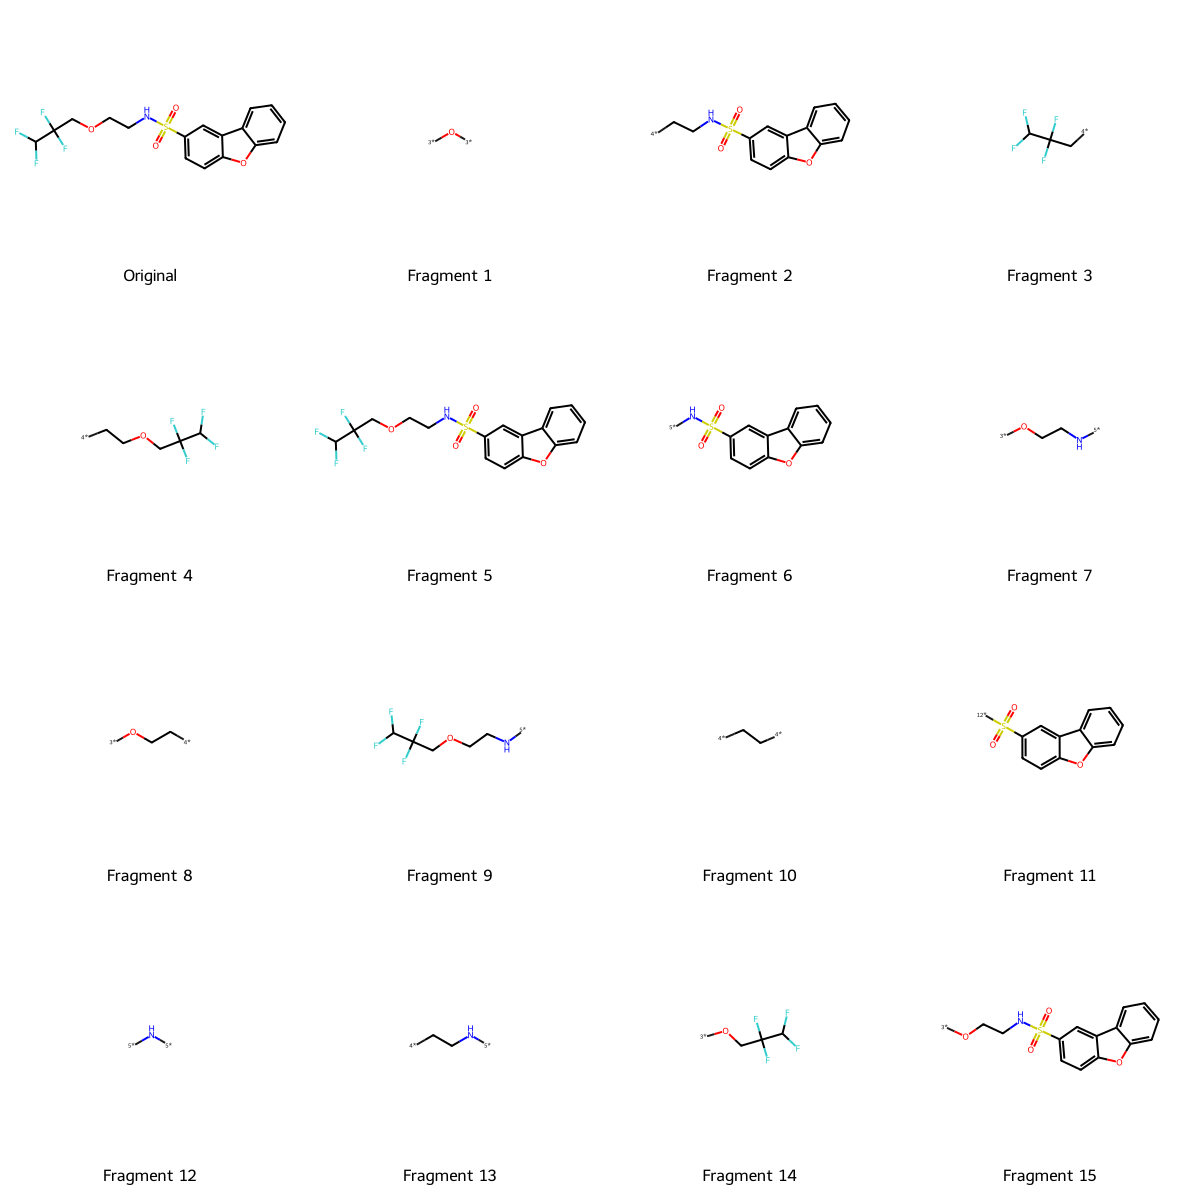


Molecule 2
SMILES: CCCCCn1c(CCNC(=O)c2cccs2)nc2ccccc21
Number of fragments: 21


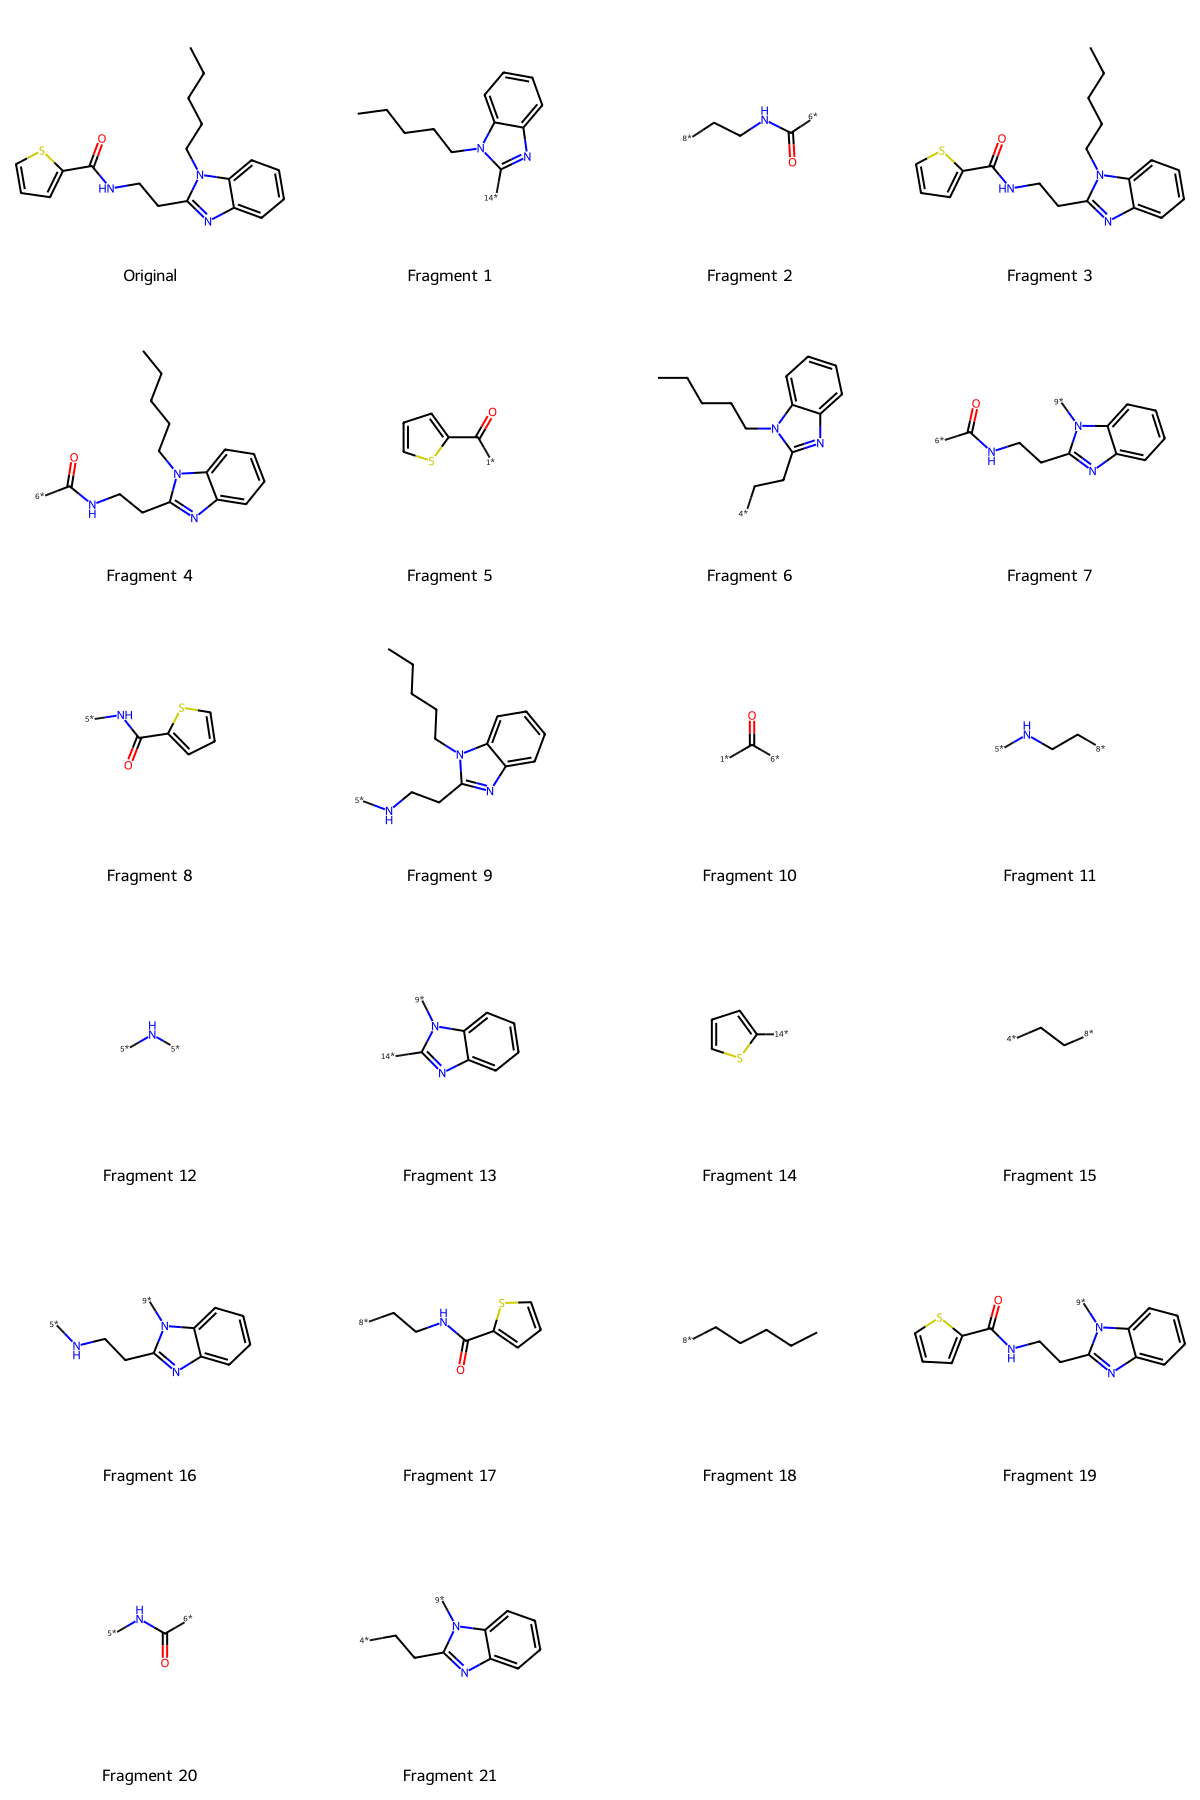


Molecule 3
SMILES: Nc1ccc2c(C(F)(F)F)cc(=O)oc2c1
Number of fragments: 3


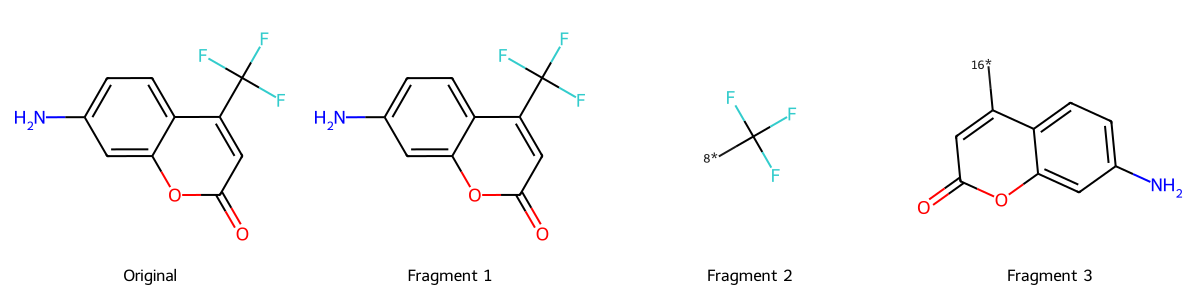


Molecule 4
SMILES: COc1cc(NC(=O)c2ccco2)c(OC)cc1NC(=O)CSc1nnc(-c2cccs2)n1C
Number of fragments: 111


/home/allenwang/miniconda3/envs/digress/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


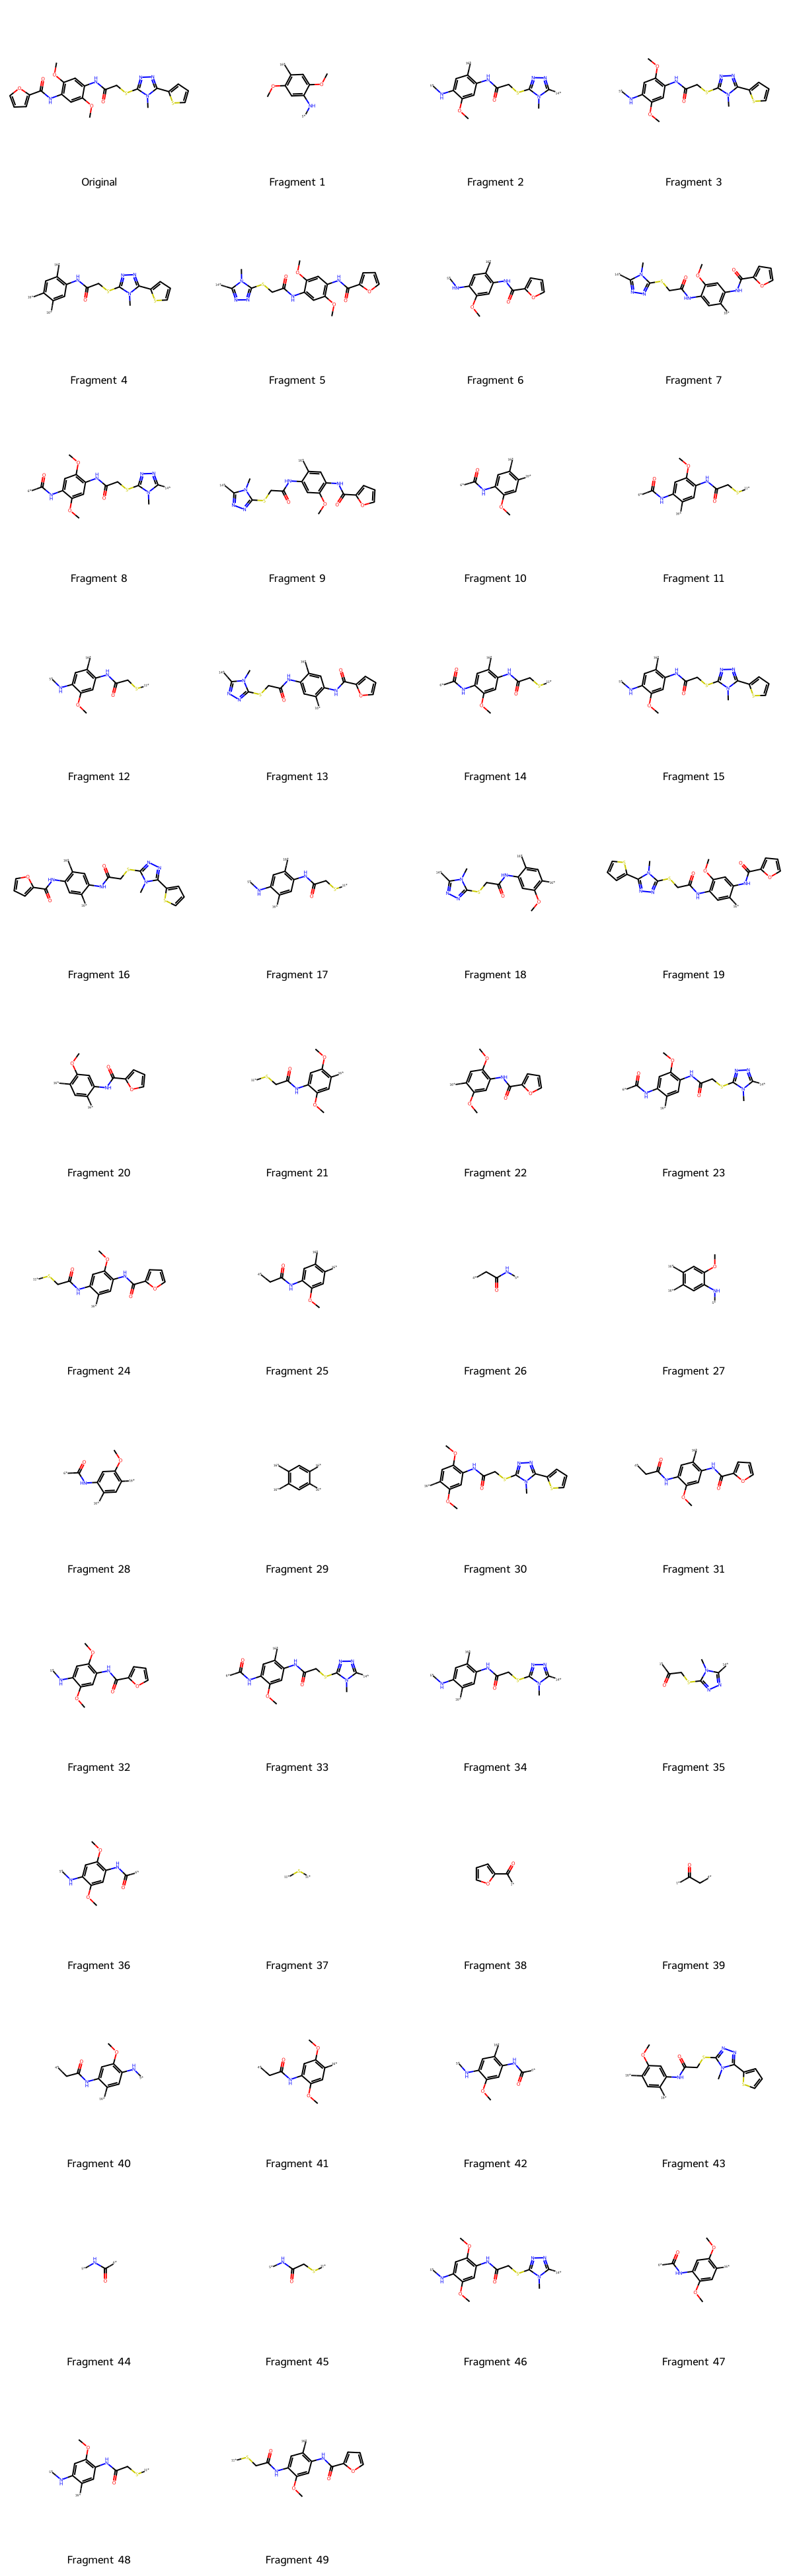


Molecule 5
SMILES: COc1ccccc1NC(=O)c1ccccc1-c1nc(-c2ccccc2OC)no1
Number of fragments: 32


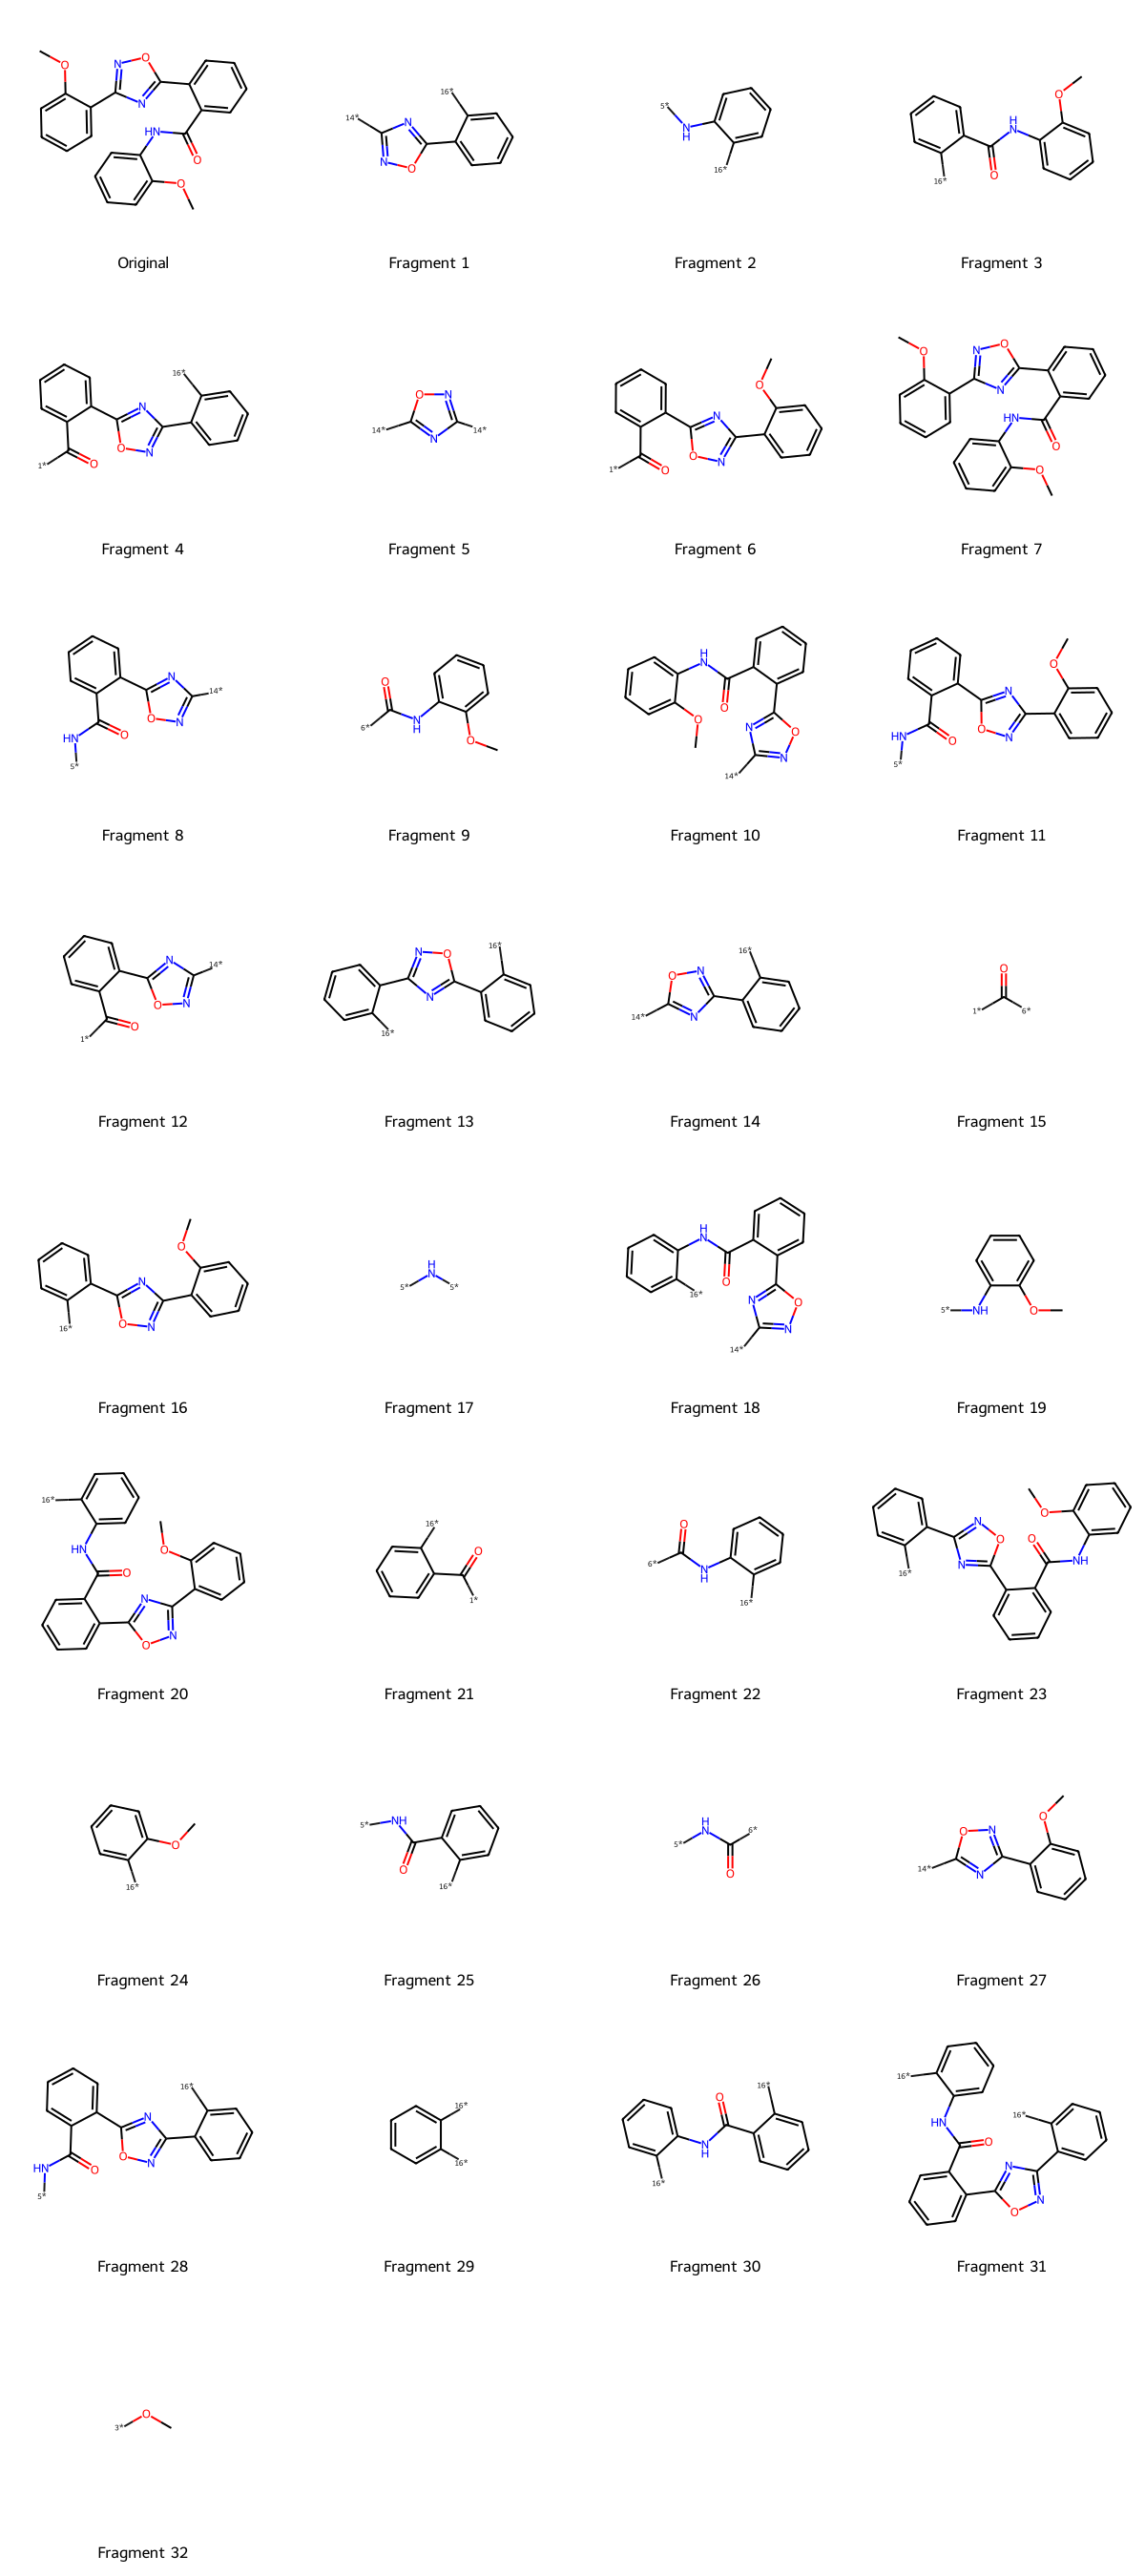

In [55]:
# visualize the original molecule and its fragments 
def visualize_molecule_and_fragments(smiles, fragments):
    # Create molecule objects
    parent_mol = Chem.MolFromSmiles(smiles)
    fragment_mols = [Chem.MolFromSmiles(frag) for frag in fragments]
    
    # Combine parent and fragments into one list
    all_mols = [parent_mol] + fragment_mols
    
    # Create legends
    legends = ['Original'] + [f'Fragment {i+1}' for i in range(len(fragments))]
    
    # Generate and display the grid image
    img = Draw.MolsToGridImage(all_mols, 
                              molsPerRow=4,  # Adjust based on preference
                              subImgSize=(300, 300),  # Adjust size as needed
                              legends=legends)
    return img

for i, (smiles, frags) in enumerate(list(fragments_dict.items())[:5]):  # Show first 5 molecules
    print(f"\nMolecule {i+1}")
    print(f"SMILES: {smiles}")
    print(f"Number of fragments: {len(frags)}")
    display(visualize_molecule_and_fragments(smiles, frags))

## Diffuse and Denoise Results

In [1]:
import matplotlib.pyplot as plt
import torch


In [2]:
a = torch.load('welqrate_data/AID1798/selected_processed/AID1798_selected_data.pt')
a[0]

Data(x=[2412, 11], edge_index=[2, 5310], edge_attr=[5310, 5], y=[98, 0], idx=[98], node_mask=[2412])

In [3]:
# generated smiles
generated_smiles_path = 'outputs/welqrate/final_smiles.txt'
with open(generated_smiles_path, 'r') as f:
    generated_smiles = f.read().splitlines()
    
# original smiles 
original_smiles = torch.load('welqrate_data/AID1798/AID1798_selected_filtered_smiles.pt')

In [4]:
# original_smiles
print(len(original_smiles))
print(len(generated_smiles))

98
98


O=C(CCN1CCN(Cc2ccc(C(F)(F)F)o2)CC1)NN=Cc1cc(Cl)c(Cl)cc1Cl
COc1ccc(-c2cc(C(F)(F)F)n3nc(C(=O)Nc4cc(C)on4)cc3n2)cc1OC


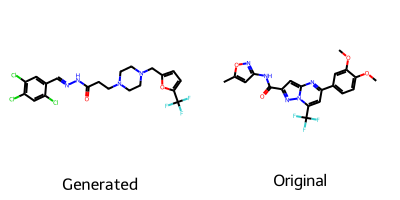

Similarity: 0.15306122448979592
Generated molecule atom count: 32
Original molecule atom count: 32
CC(=O)c1cc(C)n(C2=CC(C)=CC=C(O)C=C2)c1C
CC(=NCc1ccco1)C1=C(O)c2ccccc2C1=O


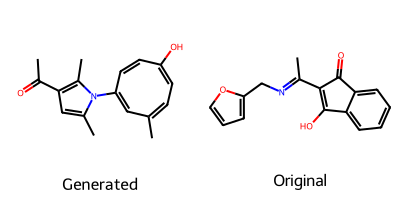

Similarity: 0.12121212121212122
Generated molecule atom count: 20
Original molecule atom count: 20
Cc1c(C=O)c(=O)n(-c2ccc(F)cc2)n1C(C)C
CCCCCc1nc2c(=O)[nH]c3ccccc3c2o1


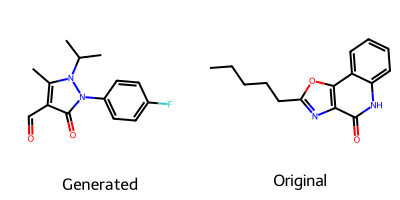

Similarity: 0.08823529411764706
Generated molecule atom count: 19
Original molecule atom count: 19
Cc1ccccc1Sc1c2noc1CCCC(C)N2
O=C(O)c1ccc2c(c1)C(c1ccccc1)OC2=O


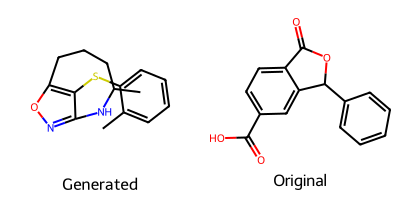

Similarity: 0.1044776119402985
Generated molecule atom count: 19
Original molecule atom count: 19
Cc1nc(NC(C)(C)C)n(CCCO)c1C(=O)c1ccco1
Cc1nn(-c2ccccc2)c(Cl)c1C(=O)Nc1c(C)n(C)n(-c2ccccc2)c1=O


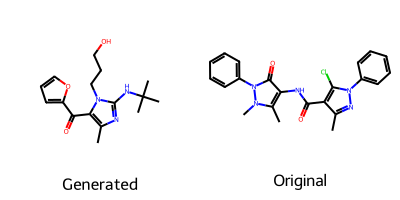

Similarity: 0.17721518987341772
Generated molecule atom count: 22
Original molecule atom count: 30
COc1c(O)cc(COc2c(N(C)CCCO)ccc3sc(C(C)O)c(C)c23)cc1C(C)O
COc1ccc(C2C(C(C)=O)=C(C)N=c3s/c(=C\c4cc(C)n(C)c4C)c(=O)n32)c(OC)c1


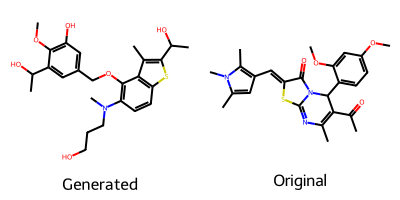

Similarity: 0.12037037037037036
Generated molecule atom count: 33
Original molecule atom count: 33
CCc1ccc(C(C=Cc2ccccc2)=NNC(=O)CO)cc1
O=C(O)c1ccccc1NCN1C(=O)C2CC=C(Cl)CC2C1=O


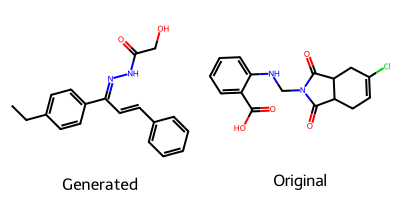

Similarity: 0.14864864864864866
Generated molecule atom count: 23
Original molecule atom count: 23
Cc1oc2nc1CS(=O)(=O)Cc1ccc-2o1
COc1ccc(-n2c(O)c(/C=N/n3cnnc3)c3ccccc3c2=O)cc1


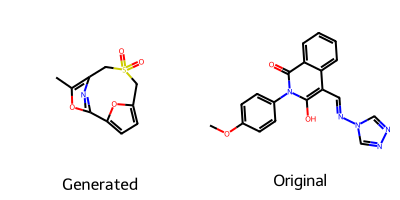

Similarity: 0.08450704225352113
Generated molecule atom count: 16
Original molecule atom count: 27
CC=C1C(=O)N(C)CC2CCN3CC2C(C)(CO)OC(=O)C1C1=C(C)C2(CCCC(C)C)SC132
O=C(CSc1nnc(Cn2nnc3ccccc32)o1)N(Cc1ccc(F)cc1)c1ccccc1


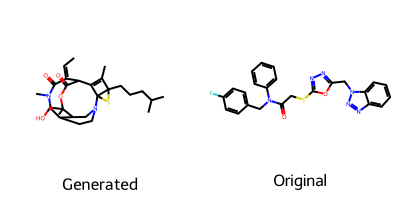

Similarity: 0.0782608695652174
Generated molecule atom count: 34
Original molecule atom count: 34
CCCC(=O)N(CCCN1CCOCC1)c1ccccc1
COC(=O)c1sccc1NC(=O)c1cc2c(s1)CCCC2


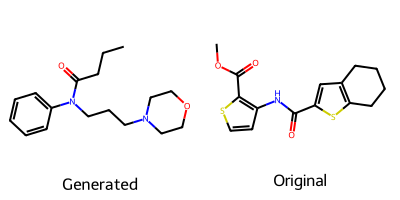

Similarity: 0.12
Generated molecule atom count: 21
Original molecule atom count: 21
Nc1c(C(=O)OCC2C=CCO2)sc2c(-c3ccsc3)c(Nc3ccccc3)nn12
Cc1cccn2c(=O)c3cc(C(=O)NC4CCCC4)c(=N)n(C4CCCC4)c3nc12


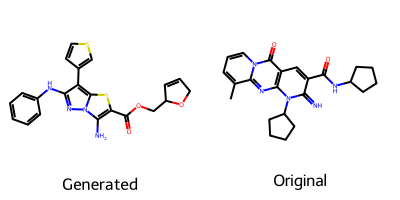

Similarity: 0.1111111111111111
Generated molecule atom count: 30
Original molecule atom count: 30
CCOc1ccc(CNC(=O)c2ccc(Br)o2)cc1
O=P1(Nc2ncccn2)COc2ccccc2OC1


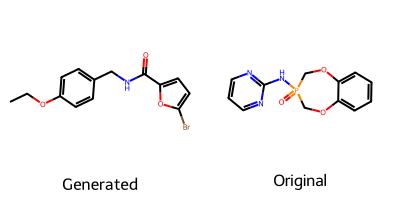

Similarity: 0.1206896551724138
Generated molecule atom count: 19
Original molecule atom count: 19
Cc1c(-c2ccccc2)c(N)nn1-c1ncnc(N)n1
O=C(NCCn1cccc1)c1cccc2ccccc12


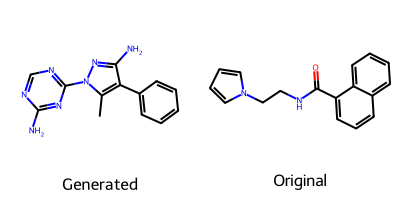

Similarity: 0.1111111111111111
Generated molecule atom count: 20
Original molecule atom count: 20
CC(C)C(N=Cc1cn(C)c(=O)n(C)c1=O)C(=O)O
Cc1ccccc1Nc1cc2ccccc2c(=O)[nH]1


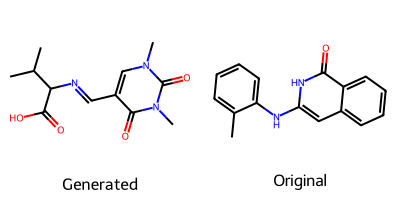

Similarity: 0.078125
Generated molecule atom count: 19
Original molecule atom count: 19
Cc1cccc(NC(C)C2=CC(=O)N(C)c3c(C)c(C)c(C)c4c3C(=O)N24)c1C
O=C(CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1


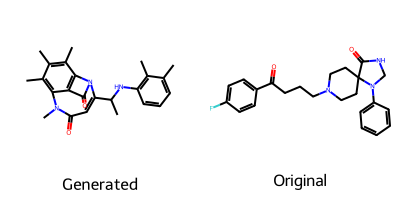

Similarity: 0.10465116279069768
Generated molecule atom count: 29
Original molecule atom count: 29
COC1OCC2(CCC1C(C)C)CC(CO)O2
CCN(CC(=O)Nc1ccc2c(c1)OCCO2)c1nc(-c2cccnc2)nc2ccccc12


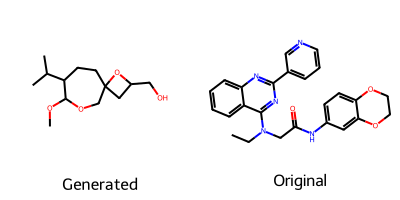

Similarity: 0.06521739130434782
Generated molecule atom count: 17
Original molecule atom count: 33
C=CCN=C1N(C)CCCN1C1=C(C(=O)C(C)C)CNc2ccccc21
COC(=O)c1ccc(CSc2nc(C(F)(F)F)c3c(c2C#N)CCC3)o1


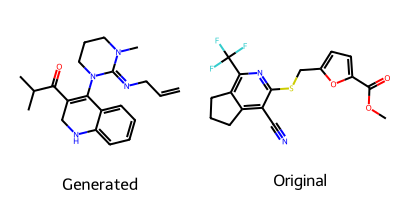

Similarity: 0.1
Generated molecule atom count: 26
Original molecule atom count: 26
CCc1nc(C)c2c(C)cc(N)c(C)c2n1
CCn1c(CCn2ccnc2C)n[nH]c1=S


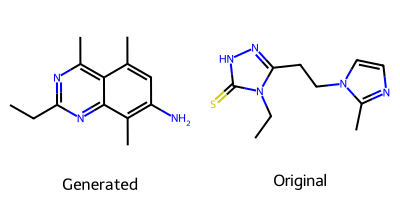

Similarity: 0.11666666666666667
Generated molecule atom count: 16
Original molecule atom count: 16
CCC(C)NC(=O)N1CCc2cc(C)ccc2C1
CN1CCCC(C(=O)C(C#N)c2ccccc2)C1


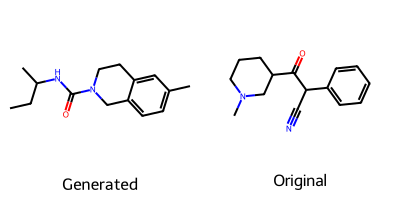

Similarity: 0.16417910447761194
Generated molecule atom count: 18
Original molecule atom count: 18
CCOc1ccccc1CN1CCCCC1
CC(C)(C)NC(=O)C(Cc1ccccc1)NS(=O)(=O)c1ccc2c(c1)CCC(=O)N2


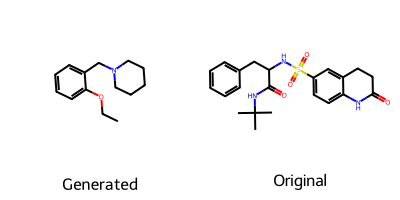

Similarity: 0.10526315789473684
Generated molecule atom count: 16
Original molecule atom count: 30
CCOC(=O)c1c(CCCC(=O)O)csc1N
CCN(CC)c1ccc2oc(=O)c(C)nc2c1


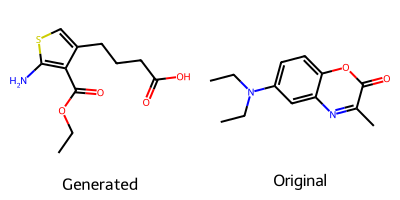

Similarity: 0.109375
Generated molecule atom count: 17
Original molecule atom count: 17
Cc1noc(C)c1-c1cc(C=N)no1
COc1ccc(N(C)S(=O)(=O)c2cccc(C(=O)NC3=NCCS3)c2)cc1


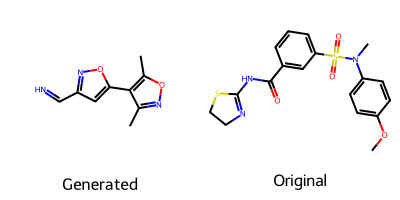

Similarity: 0.08
Generated molecule atom count: 14
Original molecule atom count: 27
Cc1ccc(NC(=S)NCCc2c(C)nc(N(C)C)nc2N2CCOCC2)cc1
Cc1nn(-c2ccccc2)c(C)c1C(=O)OC/C(O)=C(\C#N)c1nc2ccccc2[nH]1


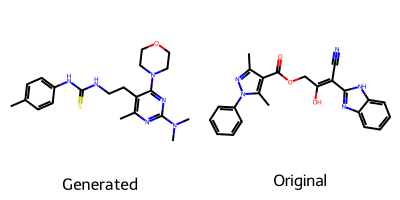

Similarity: 0.1134020618556701
Generated molecule atom count: 29
Original molecule atom count: 31
Cc1ccc(C(=O)NC2CCCCC2)o1
CCOC(=O)C1CCCN(C(=O)CN2CCN(Cc3ccc(Cl)cc3)C2=O)C1


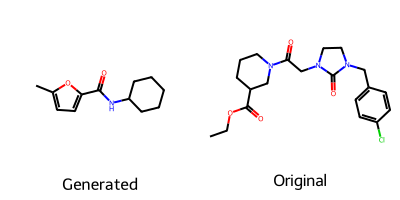

Similarity: 0.22388059701492538
Generated molecule atom count: 15
Original molecule atom count: 28
Cc1c(S(=O)(=O)N(C)C)cn(CC2CCCCO2)c(=O)c1C#N
O=C(OC1CCOC1=O)c1ccc(-c2nc3ccccc3s2)s1


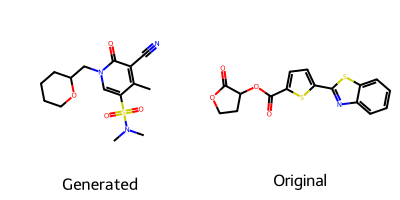

Similarity: 0.10227272727272728
Generated molecule atom count: 23
Original molecule atom count: 23
CCCCn1nc(C(=O)O)c2oc(C)cc2c1=O
Clc1ccc(-n2nnnc2-c2ccccc2)cc1


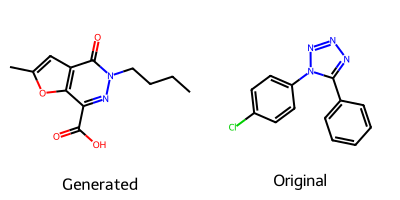

Similarity: 0.11290322580645161
Generated molecule atom count: 18
Original molecule atom count: 18
CC(C)CCNc1nc(SCC(=O)NC(C)C)nc(-c2ccco2)n1
CCOC(=O)C1CCCN(CCC(=O)Nc2ccc3c(c2)CCC3)C1


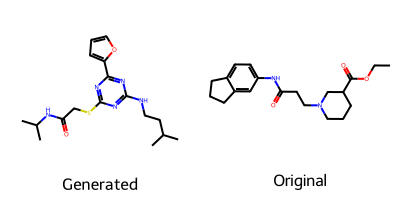

Similarity: 0.13186813186813187
Generated molecule atom count: 25
Original molecule atom count: 25
CCNc1c(NC(=O)c2ccccc2)cc(C(=O)OC)c2nsnc12
O=c1cc(CO)oc(C(Nc2ccccn2)c2ccccc2F)c1O


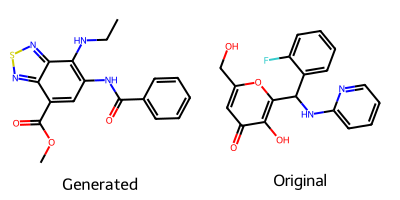

Similarity: 0.13095238095238096
Generated molecule atom count: 25
Original molecule atom count: 25
COc1ccccc1C(C)=NN=C1c2ccoc2C(=O)NN=Cc2c1ccc1c(OC)cccc21
CCOC(=O)c1cc2c(=O)n3ccccc3nc2n(Cc2ccco2)c1=NC(=O)c1cccnc1


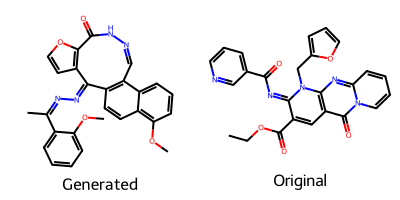

Similarity: 0.14912280701754385
Generated molecule atom count: 35
Original molecule atom count: 35
O=C1CCOC(=O)C(O)c2ccc3cc1ccc3c2
CCC(C)c1ccc(O)c(NC(=O)c2ncn[nH]2)c1


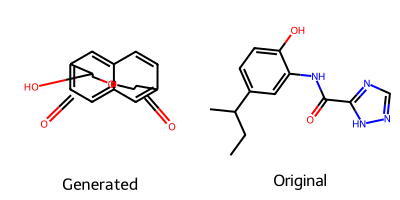

Similarity: 0.08695652173913043
Generated molecule atom count: 19
Original molecule atom count: 19
CCc1ccccc1-n1c2nc3nc(n(C)c3c1=O)SC(C(=O)NC(C)(C)C)CC2
COc1ccccc1NC(=O)c1ccccc1-c1nc(-c2ccccc2OC)no1


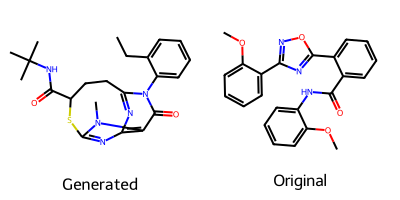

Similarity: 0.1348314606741573
Generated molecule atom count: 30
Original molecule atom count: 30
CCC(CC)NC(=O)Nc1ccncc1
C(\CCc1ccccc1)=N/n1cnnc1


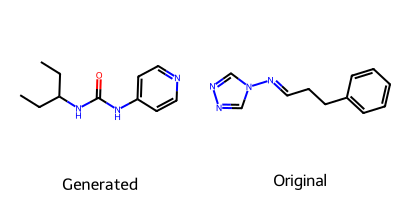

Similarity: 0.09615384615384616
Generated molecule atom count: 15
Original molecule atom count: 15
Cc1nc2c(=O)n(N)c(C(Br)=CO)nc2n1C
Nc1cc(N)nc(SCCN2CCCCC2)n1


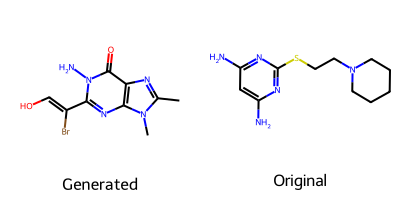

Similarity: 0.1016949152542373
Generated molecule atom count: 17
Original molecule atom count: 17
CCOC(=O)c1cc(Nc2ccc(O)cc2)ncn1
CCc1ccc(-c2cn3nc(C)c(C)nc3n2)cc1


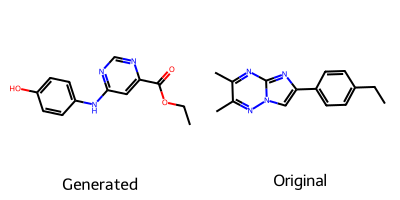

Similarity: 0.14516129032258066
Generated molecule atom count: 19
Original molecule atom count: 19
CC(=O)OCCOCc1cncnc1C#N
C=C1c2cc(OC)ccc2NC(=O)N1CC


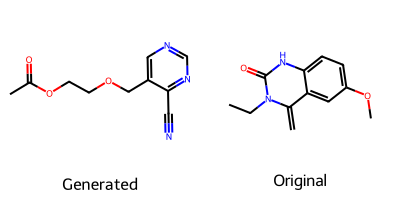

Similarity: 0.08955223880597014
Generated molecule atom count: 16
Original molecule atom count: 16
CCOc1cc(C2C(C(=O)OCCO)=C(C)NC3=C2C(=O)CC(C)(CC)C3)ccc1OC
CCN(CC)S(=O)(=O)c1ccc2oc(SCC3CN=C(c4ccc(OC)cc4)S3)nc2c1


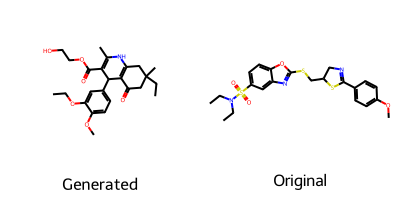

Similarity: 0.12037037037037036
Generated molecule atom count: 32
Original molecule atom count: 32
COC(=O)c1c2ccn1-c1ccc(cc1)C(C)(C)c1ccccc1-2
Cc1c(C#N)c2ncnc(-c3ccccc3)c2n1-c1ccccc1


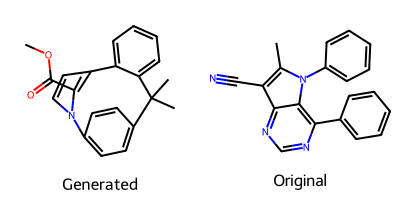

Similarity: 0.16417910447761194
Generated molecule atom count: 24
Original molecule atom count: 24
CCN(C(C)CCNc1nc(N(C)C)nc(N2CCOCC2)n1)C1CCCCC1
CC1CCN(c2nc3ccccc3nc2C(C#N)C(=O)NC2CCCCC2)CC1


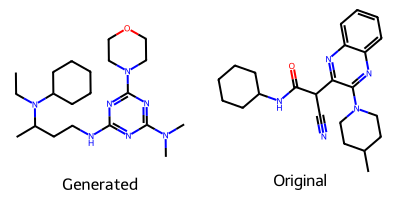

Similarity: 0.19540229885057472
Generated molecule atom count: 29
Original molecule atom count: 29
C=CC1=Nc2c(OCC)c1c1c(C)c2C(C)=C(CCC2COCC(OC)C2O)C(=O)O1
COC(=O)c1ccc(OCC2c3cc(OC)c(OC)cc3CCN2C(=O)C2CC2)cc1


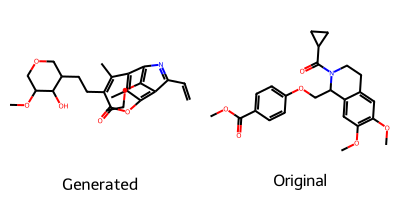

Similarity: 0.09523809523809523
Generated molecule atom count: 31
Original molecule atom count: 31
CCSc1ccc(Cc2cc(C)sc2C(C)=NNC(=O)c2ccc(C)o2)nc1
COc1ccc(-c2cc3ccccc3n2CC(O)Cn2nc(C)cc2C)cc1


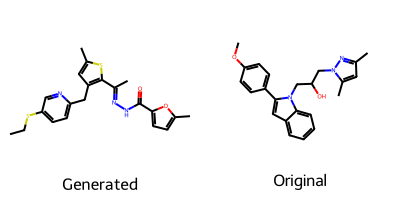

Similarity: 0.1134020618556701
Generated molecule atom count: 28
Original molecule atom count: 28
Cc1c(C)n(CC2OOC(=O)C2(C)C)c2ccccc12
CC(=O)CCc1ccc(OC(=O)c2cccnc2)cc1


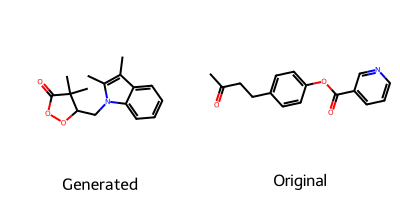

Similarity: 0.1
Generated molecule atom count: 20
Original molecule atom count: 20
CCC(=Nc1cccnc1)c1ccccc1C(=O)NN
O=C(Cc1ccc(Cl)c(Cl)c1)OCC(=O)c1ccc[nH]1


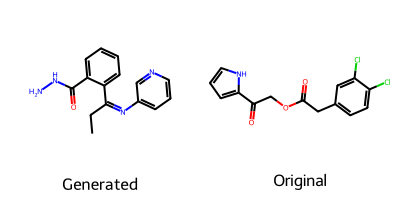

Similarity: 0.11428571428571428
Generated molecule atom count: 20
Original molecule atom count: 20
CC(=O)C1=C(CN(CCO)Cc2ccccc2)N=C1C
c1coc(-c2nc3ccccc3nc2-c2ccco2)c1


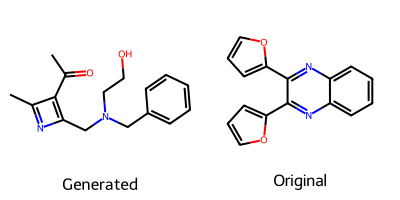

Similarity: 0.1111111111111111
Generated molecule atom count: 20
Original molecule atom count: 20
O=C(CSc1nnnn1Cc1ccc(Nc2ccccc2)cc1)NCC1CCCCC1
CCOC(=O)c1c(-c2ccccc2)nnn1-c1nc(OCC)nc(N2CCCCC2)n1


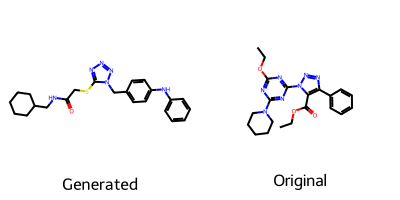

Similarity: 0.18888888888888888
Generated molecule atom count: 31
Original molecule atom count: 31
CCOc1ccc2oc(=O)c3cc(OC)ccc3c2c1Cc1ccc(O)cc1O
O=C(O)c1ccccc1-c1ccc(/C=c2\sc3nc4cc(Br)cnc4n3c2=O)o1


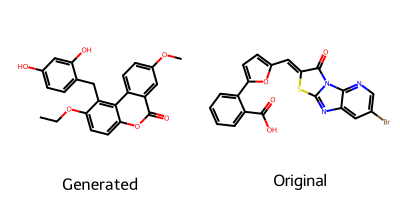

Similarity: 0.1111111111111111
Generated molecule atom count: 29
Original molecule atom count: 29
Cc1ccc(Cc2ccc(-c3ccc(C)cc3O)o2)cc1
O=c1oc2c3c4c(cc2c2c1CCC2)OCCN4CCC3


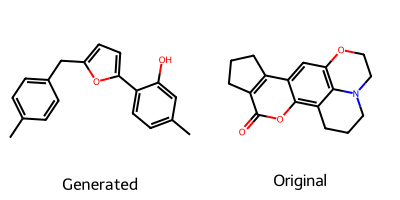

Similarity: 0.09375
Generated molecule atom count: 21
Original molecule atom count: 21
Clc1cc2cc(c1)c1nc(nc(-c3ccccc3)[nH]2)sc1CN1CCOCC1
CCCCN(C(=O)c1cc(OC)c(OC)c(OC)c1)C1=CC2CCC(C1)N2C


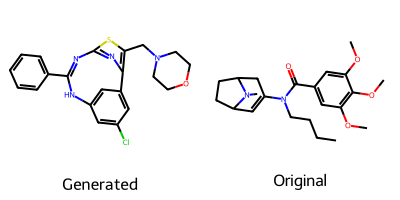

Similarity: 0.061855670103092786
Generated molecule atom count: 28
Original molecule atom count: 28
N#CCc1cc(N)sc1C#N
CC(=O)Nc1nc2ccccc2n1CCN1CCOCC1


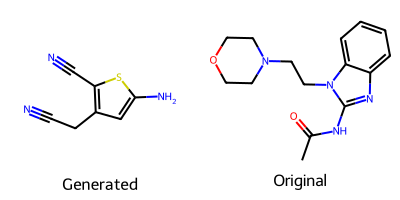

Similarity: 0.046875
Generated molecule atom count: 11
Original molecule atom count: 21
Nc1sccc1C(=O)N1CCN(Cc2ccc(F)cc2)CC1
CN1C(=O)C(Cc2cccc3ccccc23)C(=O)N(C)C1=O


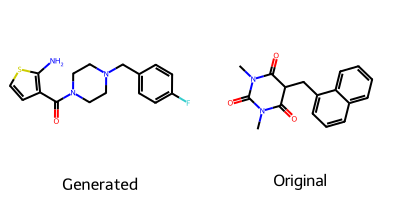

Similarity: 0.09090909090909091
Generated molecule atom count: 22
Original molecule atom count: 22
CC1(C)CC(=O)C(c2nc3ccccc3s2)=C(O)C1
CN(C)/C=C1\N=C(c2ccc3c(c2)OCO3)OC1=O


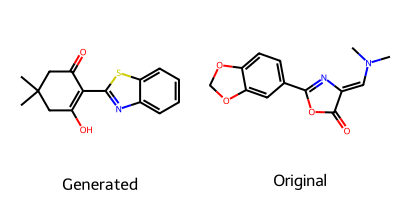

Similarity: 0.1323529411764706
Generated molecule atom count: 19
Original molecule atom count: 19
CCCC1N=C(NCC(C)(C)NC(=O)COc2ccccc2C)C1(C)C
CN1C(=O)C(CC(=O)Nc2ccc3c(c2)Cc2ccccc2-3)N(C)C1=O


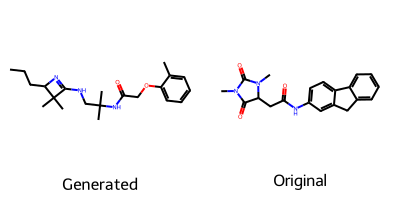

Similarity: 0.15294117647058825
Generated molecule atom count: 26
Original molecule atom count: 26
COc1ccc(CC=C(c2ccc(Cl)cc2)C(C)C)c(COCCO)c1
CC1CCc2c(C(=O)N3CCN(S(=O)(=O)c4cccs4)CC3)csc2C1


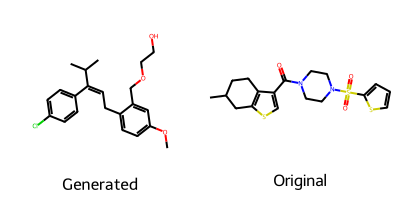

Similarity: 0.05434782608695652
Generated molecule atom count: 26
Original molecule atom count: 26
COc1ccc(C)cc1Oc1ncccc1O
O=[n+]1c2c(n(O)c3c1CCCC3)CCCCC2


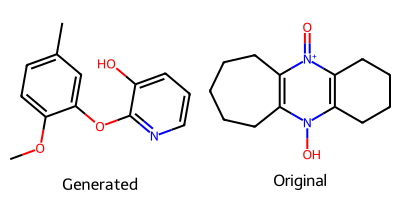

Similarity: 0.03773584905660377
Generated molecule atom count: 17
Original molecule atom count: 17
O=C1COc2ccccc2N1
CC1(C)C(=O)OC(C(=O)c2ccccc2)C(C)(C)C1=O


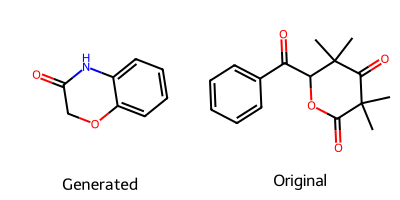

Similarity: 0.19148936170212766
Generated molecule atom count: 11
Original molecule atom count: 20
c1ccc(COc2nc3nc(n2)O3)cc1
CCOC(=O)N1CCN(c2c(NCc3ccccn3)c(=O)c2=O)CC1


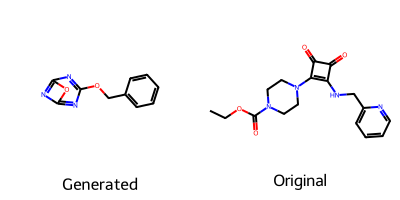

Similarity: 0.15873015873015872
Generated molecule atom count: 15
Original molecule atom count: 25
COc1cccc(C(C)NC(=O)Cc2c(-c3ccccc3)nn(C)c2C)c1
CCn1c2ccccc2c2nnc(SCc3cc(=O)n4ccsc4n3)nc21


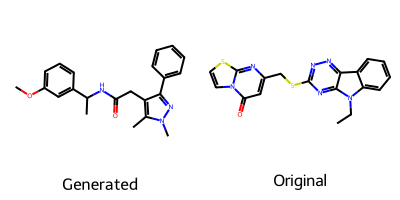

Similarity: 0.12631578947368421
Generated molecule atom count: 27
Original molecule atom count: 27
Cc1ccc(NCC2=CC=C3SC=NN3c3cccnc32)cc1F
O=C(CCN1C(=O)C2CC=C(Cl)CC2C1=O)Nc1ccccc1O


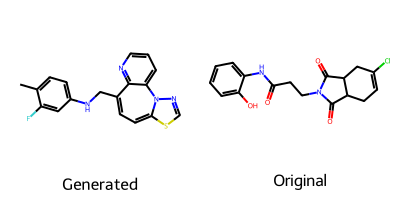

Similarity: 0.08045977011494253
Generated molecule atom count: 24
Original molecule atom count: 24
COc1c(C)cc(C)cc1C(=O)Nc1ccc(C)cn1
O=c1[nH]cnc2scc(C3COc4ccccc4O3)c12


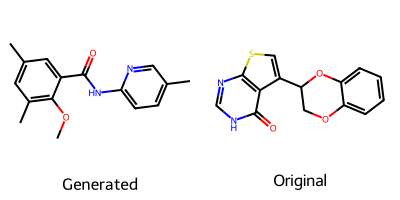

Similarity: 0.08108108108108109
Generated molecule atom count: 20
Original molecule atom count: 20
CCCC(=NNC1=NCCN1)c1ccccc1
O=C1N/C(=C\c2ccccc2)c2ccccc21


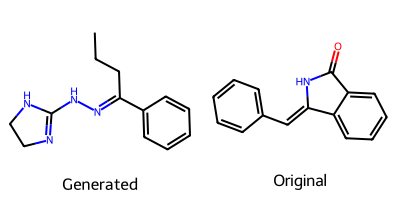

Similarity: 0.125
Generated molecule atom count: 17
Original molecule atom count: 17
Cc1ccc(-n2nccc2CNC(=O)c2cc3c(s2)CN(C)C(C)C3)cc1
CCOC(=O)c1nnn(-c2nonc2N)c1CN1CCc2ccccc2C1


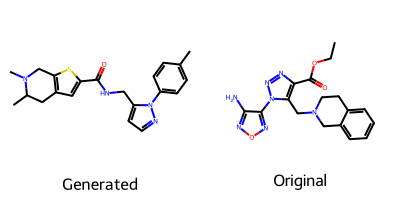

Similarity: 0.1702127659574468
Generated molecule atom count: 27
Original molecule atom count: 27


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem

for i in range(len(generated_smiles)):
    if generated_smiles[i] != 'None':
        print(generated_smiles[i])
        print(original_smiles[i])
        # plot both smiles with RDKit

        generated_mol = Chem.MolFromSmiles(generated_smiles[i])
        original_mol = Chem.MolFromSmiles(original_smiles[i])

        if generated_mol and original_mol:
            img = Draw.MolsToGridImage([generated_mol, original_mol], molsPerRow=2, subImgSize=(200, 200), legends=['Generated', 'Original'])
            display(img)
            
            # Calculate similarity
            fp1 = AllChem.GetMorganFingerprintAsBitVect(generated_mol, 2, nBits=2048)
            fp2 = AllChem.GetMorganFingerprintAsBitVect(original_mol, 2, nBits=2048)
            similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
            print(f"Similarity: {similarity}")
    
            generated_atom_count = generated_mol.GetNumAtoms()
            original_atom_count = original_mol.GetNumAtoms()
            print(f"Generated molecule atom count: {generated_atom_count}")
            print(f"Original molecule atom count: {original_atom_count}")